# Non-Parametric Regression

In [1]:
# Setup
%matplotlib inline
from utils.lecture03 import *

### Dataset

For this session, we are mostly going to work with the wage dataset.

In [2]:
df = pd.read_csv('data/Wage.csv', index_col=0)
df.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


This dataset contains information on wages and individual characteristics.

Our main objective is going to be to explain wages using the observables contained in the dataset.

## Polynomial Regression and Step Functions

As we have seen in the first lecture, the most common way to introduce linearities is to replace the standard linear model 

$$
y_i = \beta_0 + \beta_1 x_i + \varepsilon_i
$$

with a polynomial function

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i
$$

### Explore the Data

Suppose we want to investigate the relationship between `wage` and `age`. Let's first plot the two variables.

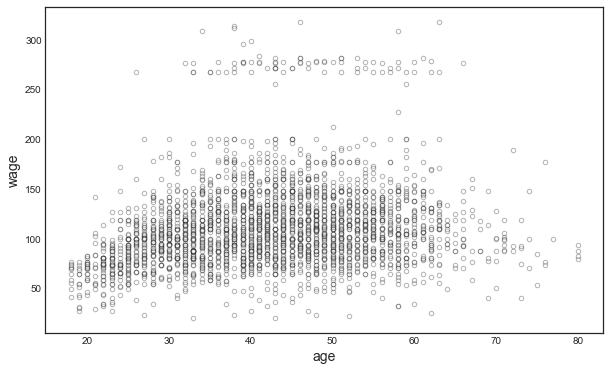

In [3]:
# Scatterplot of the data
df.plot.scatter('age','wage',color='w', edgecolors='k', alpha=0.3);

### Polynomials of different degrees

The relationship is highly complex and non-linear. Let's expand our linear regression polynomials of different degrees: 1 to 5.

In [4]:
X_poly1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X_poly2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X_poly3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X_poly4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X_poly5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

### Variables

Our dependent varaible is going to be a dummy for income above 250.000 USD.

In [5]:
# Get X and y
X = df.age
y = df.wage
y01 = (df.wage > 250).map({False:0, True:1}).values

### Polynomia Regression

If we run a linear regression on a 4-degree polinomial expansion of `age`, this is what it looks like`:

In [6]:
# Fit ols on 4th degree polynomial
fit = sm.OLS(y, X_poly4).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


### Measures of Fit

In this case, the single coefficients are not of particular interest. We are mostly interested in the best capturing the relationship between `age` and `wage`. How can we pick among thedifferent polynomials?

We compare different polynomial degrees. For each regression, we are going to look at a series of metrics:
 - absolute residuals
 - sum of squared residuals
 - the difference in SSR w.r (SSR).t the 0-degree case
 - F statistic

In [7]:
# Run regressions
fit_1 = sm.OLS(y, X_poly1).fit()
fit_2 = sm.OLS(y, X_poly2).fit()
fit_3 = sm.OLS(y, X_poly3).fit()
fit_4 = sm.OLS(y, X_poly4).fit()
fit_5 = sm.OLS(y, X_poly5).fit()

# Compare fit
sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The polynomial degree 4 seems best.

In [8]:
# Set polynomial X to 4th degree
X_poly = X_poly4

### Binary Dependent Variable

Since we have a binary dependent variable, it would be best to account for it in our regression framework. One way to do so, is to run a logistic regression. 

How to interpret a Logistic Regression?

$$
y = \mathbb I \ \Big( \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i \Big)
$$

where $\mathbb I(\cdot)$ is an indicator function and now $\varepsilon_i$ is the error term.

### Binomial Link Functions

Depending on the assumed distribution of the error term, we get different results. I list below the error types supported by the `Binomial` family. 

In [9]:
# List link functions for the Binomial family
sm.families.family.Binomial.links

[statsmodels.genmod.families.links.logit,
 statsmodels.genmod.families.links.probit,
 statsmodels.genmod.families.links.cauchy,
 statsmodels.genmod.families.links.log,
 statsmodels.genmod.families.links.cloglog,
 statsmodels.genmod.families.links.identity]

### Logit Link Function

We are going to pick the `logit` link, i.e. we are going to assume that the error term is Type 1 Extreme Value (or Gumbel) distributed. It instead we take the usual standard normal distribution assumption for $\varepsilon_i$, we get `probit` regression.

In [10]:
# Pick the logit link for the Binomial family
logit_link = sm.families.Binomial(sm.genmod.families.links.logit())

Given the error distribution, we can write the probability that $y=1$ as

$$
\Pr(y=1) = \frac{e^{ \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i }}{1 + e^{ \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i } }
$$

### Logistic Regression

We now estimate the regression and plot the estimated relationship between `age` and `wage`.

In [11]:
# Run logistic regression
logit_poly = sm.GLM(y01, X_poly, family=logit_link).fit()
logit_poly.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-109.5530,47.655,-2.299,0.022,-202.956,-16.150
x1,8.9950,4.187,2.148,0.032,0.789,17.201
x2,-0.2816,0.135,-2.081,0.037,-0.547,-0.016
x3,0.0039,0.002,2.022,0.043,0.000,0.008
x4,-1.949e-05,9.91e-06,-1.966,0.049,-3.89e-05,-6.41e-08


### Linear Model Comparison

What is the difference with the linear model?

In [12]:
# Run OLS regression with binary outcome
ols_poly = sm.OLS(y01, X_poly).fit()
ols_poly.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.1126,0.240,-0.468,0.640,-0.584,0.359
x1,0.0086,0.024,0.363,0.717,-0.038,0.055
x2,-0.0002,0.001,-0.270,0.787,-0.002,0.001
x3,3.194e-06,1.23e-05,0.260,0.795,-2.09e-05,2.73e-05
x4,-1.939e-08,6.57e-08,-0.295,0.768,-1.48e-07,1.09e-07


The magnitude of the coefficients is different, but the signs are the same.

### Plot data and predictions

Let's plot the estimated curves against the data distribution.

In [13]:
# Generate predictions
x_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
X_poly_test = PolynomialFeatures(4).fit_transform(x_grid)
y_hat1 = sm.OLS(y, X_poly).fit().predict(X_poly_test)
y01_hat1 = logit_poly.predict(X_poly_test)

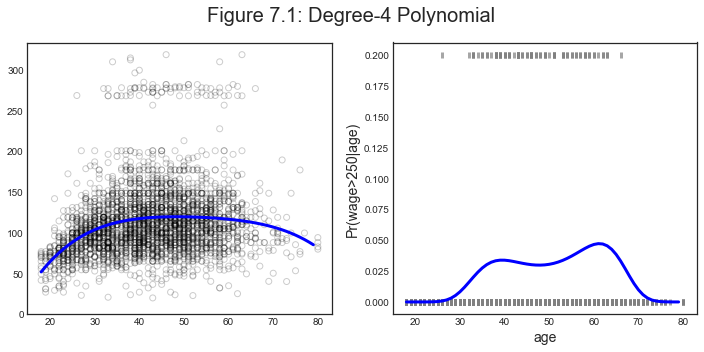

In [14]:
plot_predictions(X, y, x_grid, y01, y_hat1, y01_hat1, 'Figure 7.1: Degree-4 Polynomial')

Which is remindful of 
![Le Petit Prince - Elephant figure](../figures/nonlinearities.jpg "Nonlinearities")

Using polynomial functions of the features as predictors in a linear model imposes a global structure on the non-linear function of `age`. We can instead use step functions in order to avoid imposing such a global structure. 

For example, we could break the range of `age` into bins, and fit a different constant in each bin.

## Step Functions

Building a step function means first picking $K$ cutpoints $c_1 , c_2 , . . . , c_K$ in the range of `age`,
and then construct $K + 1$ new variables

$$
C_0(`age`) = \mathbb I ( `age` < c_1) \\
C_1(`age`) = \mathbb I ( c_1 < `age` < c_2) \\
C_2(`age`) = \mathbb I ( c_2 < `age` < c_3) \\
... \\
C_{K-1}(`age`) = \mathbb I ( c_{K-1} < `age` < c_K) \\
C_K(`age`) = \mathbb I ( c_K < `age`) \\
$$

where $\mathbb I(\cdot)$ is the indicator function.

### Binning

First, we generate the cuts.

In [15]:
# Generate cuts for the variable age
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)
type(df_cut)

pandas.core.series.Series

Let's generate a DataFrame out of this series.

In [16]:
# Generate bins for "age" from the cuts
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
231655,18,"(17.938, 33.5]",75.043154
86582,24,"(17.938, 33.5]",70.476020
161300,45,"(33.5, 49.0]",130.982177
155159,43,"(33.5, 49.0]",154.685293
11443,50,"(49.0, 64.5]",75.043154


### Dummy Variables

Now we can generate different dummy variables out of each bin.

In [17]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)
df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,1,0,0,0
86582,1.0,1,0,0,0
161300,1.0,0,1,0,0
155159,1.0,0,1,0,0
11443,1.0,0,0,1,0


### Stepwise Regression

We are now ready to run our regression

In [18]:
# Generate our new X variable
X_step = df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)

# OLS Regression on step functions
ols_step = sm.OLS(y, X_step).fit()
ols_step.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.264,97.053
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.466,27.641
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.610,27.719
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.139,17.420


From the regression outcome we can see that most bin coefficients are significant, except for the last one.

In [19]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(x_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [20]:
# Get dummies, drop first dummy category, add constant
X_step_test = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_step_test.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


In [21]:
# Step prediction
y_hat2 = ols_step.predict(X_step_test)

### Logistic Step Regression

We are going again to run a logistic regression, given that our outcome is binary.

In [22]:
# Logistic regression on step functions
logit_step = sm.GLM(y01, X_step, family=logit_link).fit()
y01_hat2 = logit_step.predict(X_step_test)
logit_step.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-5.0039,0.449,-11.152,0.000,-5.883,-4.124
"(33.5, 49.0]",1.5998,0.474,3.378,0.001,0.672,2.528
"(49.0, 64.5]",1.7147,0.488,3.512,0.000,0.758,2.672
"(64.5, 80.0]",0.7413,1.102,0.672,0.501,-1.420,2.902


### Plotting

How does the predicted function looks like?

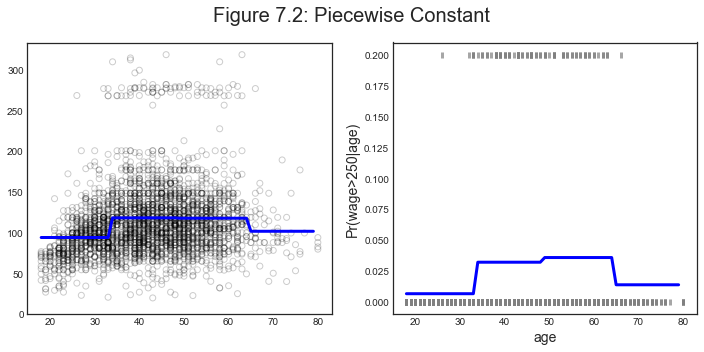

In [23]:
plot_predictions(X, y, x_grid, y01, y_hat2, y01_hat2, 'Figure 7.2: Piecewise Constant')

## Regression Splines

Spline regression, or piece-wise polynomial regression, involves fitting separate low-degree polynomials
over different regions of $X$. The idea is to have one regression specification but with different coefficients in different parts of the $X$ range. The points where the coefficients change are called knots.

For example, we could have a third degree polynomial *and* splitting the sample in two.

$$
y_{i}=\left\{\begin{array}{ll}
\beta_{01}+\beta_{11} x_{i}+\beta_{21} x_{i}^{2}+\beta_{31} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i}<c \\
\beta_{02}+\beta_{12} x_{i}+\beta_{22} x_{i}^{2}+\beta_{32} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i} \geq c
\end{array}\right.
$$

We have now two sets of coefficients, one for each subsample.

Generally, using more knots leads to a more flexible piecewise polynomial. Also increasing the degree of the polynomial increases the degree of flexibility.

### Example

We are now going to plot 4 different examples for the `age` `wage` relationship:

1. Discontinuous piecewise cubic
2. Continuous piecewise cubic
3. Quadratic (continuous)
4. Continuous piecewise linear

In [24]:
# Cut dataset
df_short = df.iloc[:80,:]
X_short = df_short.age
y_short = df_short.wage
x_grid_short = np.arange(df_short.age.min(), df_short.age.max()+1).reshape(-1,1)

# 1. Discontinuous piecewise cubic
spline1 = "bs(x, knots=(50,50,50,50), degree=3, include_intercept=False)"

# 2. Continuous piecewise cubic
spline2 = "bs(x, knots=(50,50,50), degree=3, include_intercept=False)"

# 3. Quadratic (continuous)
spline3 = "bs(x, knots=(%s,%s), degree=2, include_intercept=False)" % (min(df.age), min(df.age))

# 4. Continuous piecewise linear
spline4 = "bs(x, knots=(%s,50), degree=1, include_intercept=False)" % min(df.age)

### Generate Predictions

In [25]:
# Generate spline predictions
def fit_predict_spline(spline, X, y, x_grid):
    transformed_x = dmatrix(spline, {"x": X}, return_type='dataframe')
    fit = sm.GLM(y, transformed_x).fit()
    y_hat = fit.predict(dmatrix(spline, {"x": x_grid}, return_type='dataframe'))
    return y_hat

y_hats = [fit_predict_spline(s, X_short, y_short, x_grid_short) for s in [spline1, spline2, spline3, spline4]]

### Plotting

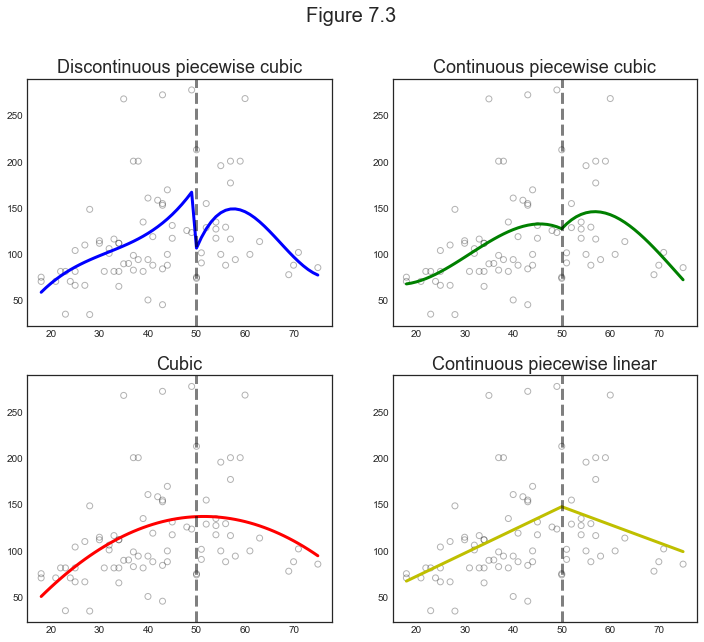

In [26]:
plot_splines(df_short, x_grid_short, y_hats)

### Comment

The first example makes us think on why would we want out function to be discontinuous. Unless we expect a sudden wage jump at a certain age, we would like the function to be continuous. However, if for example we split `age` around the retirement age, we might expect a discontinuity. 

The second example (top right) makes us think on why would we want out function not to be differentiable. Unless we have some specific mechanism in mind, ususally there is a trade-off between making the function non-differentiable or increasing the degree of the polynomial, as the last two examples show us. We get a similar fit with a quadratic fit or a discontinuous linear fit. The main difference is that in the second case we are picking the discontinuity point by hand instead of letting the data choose how to change the slope of the curve.

### The Spline Basis Representation

How can we fit a piecewise degree-d polynomial under the constraint that it (and possibly its first d − 1 derivatives) be continuous?

The most direct way to represent a cubic spline is to start off with a basis for a cubic polynomial—namely, x,x2,x3—and then add one truncated power basis function per knot. A truncated power basis function is defined as

$$ 
h(x, c)=(x-c)_{+}^{3} = \Bigg\{\begin{array}{cl}
(x-c)^{3} & \text { if } x>c \\
0 & \text { otherwise }
\end{array}
$$

One can show that adding a term of the form $\beta_4 h(x, c)$ to the model for a cubic polynomial will lead to a discontinuity in only the third derivative at $c$; the function will remain continuous, with continuous first and second derivatives, at each of the knots.

### Cubic Splines

One way to specify the spline is using nodes and degrees of freedom.

In [27]:
# Specifying 3 knots and 3 degrees of freedom
spline5 = "bs(x, knots=(25,40,60), degree=3, include_intercept=False)"
pred5 = fit_predict_spline(spline5, X, y, x_grid)

### No Knots

When we fit a spline, where should we place the knots? 

The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

In [28]:
# Specifying degree 3 and 6 degrees of freedom 
spline6 = "bs(x, df=6, degree=3, include_intercept=False)"
pred6 = fit_predict_spline(spline6, X, y, x_grid)

### Natural Splines

A natural spline is a regression spline with additional boundary constraints: the function is required to be linear at the boundary (in the region where X is smaller than the smallest knot, or larger than the largest knot). This addi- tional constraint means that natural splines generally produce more stable estimates at the boundaries.

In [29]:
# Natural spline with 4 degrees of freedom
spline7 = "cr(x, df=4)"
pred7 = fit_predict_spline(spline7, X, y, x_grid)

### Comparison

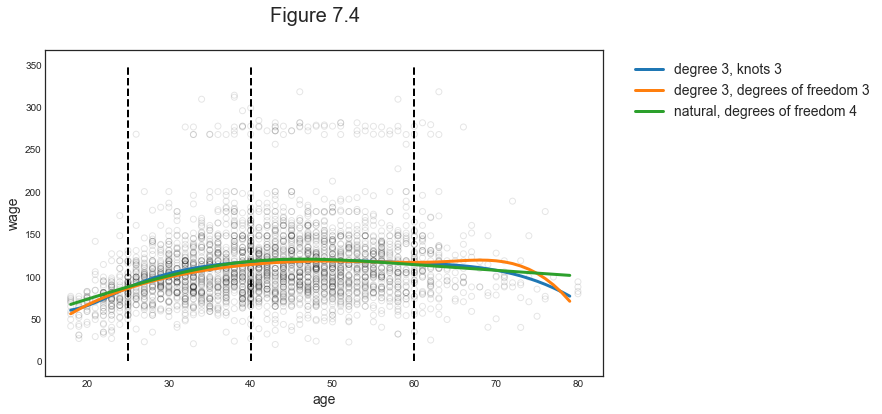

In [30]:
# Compare predictons
preds = [pred5, pred6, pred7]
labels = ['degree 3, knots 3', 'degree 3, degrees of freedom 3', 'natural, degrees of freedom 4']
compare_predictions(X, y, x_grid, preds, labels)

### Comparison to Polynomial Regression

Regression splines often give superior results to polynomial regression. This is because unlike polynomials, which must use a high degree to produce flexible fits, splines introduce flexibility by increasing the number of knots but keeping the degree fixed. 

We are now fitting a polynomial of degree 15 and a spline with 15 degrees of freedom.

In [31]:
# Polynomial of degree 15
X_poly15 = PolynomialFeatures(15).fit_transform(df.age.values.reshape(-1,1))
ols_poly_15 = sm.OLS(y, X_poly15).fit()
pred8 = ols_poly_15.predict(PolynomialFeatures(15).fit_transform(x_grid))

# Spline with 15 degrees of freedon
spline9 = "bs(x, df=15, degree=3, include_intercept=False)"
pred9 = fit_predict_spline(spline9, X, y, x_grid)

### Plotting

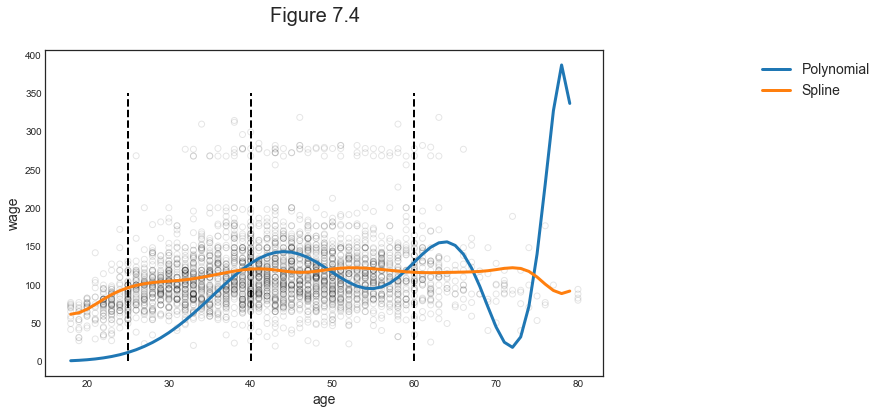

In [32]:
# Compare predictons
preds = [pred8, pred9]
labels = ['Polynomial', 'Spline']
compare_predictions(X, y, x_grid, preds, labels)

As we can see, despite the two regressions having the same degrees of freedom, the polynomial fit is much more volatile. We can compare them along some dimensions.

## Local Regression

So far we have looked at so-called "*global methods*": methods that try to fit a unique function specification over the whole data. The function specification can be complex, as in the case of splines, but can be expressed globally.

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations.

### Details

How does local regression work?

Ingredients: $X$, $y$.

How to you output a prediction $\hat y_i$ at a new point $x_i$?

1. Take a number of points in $X$ close to $x_i$: $X_{\text{close-to-i}}$
2. Assign a weight to each of there points
3. Fit a weigthed least squares regression of $X_{\text{close-to-i}}$ on $y_{\text{close-to-i}}$
4. Use the estimated coefficients $\hat \beta$ to predict $\hat y_i = \hat \beta_0 + \hat \beta_1 x_i$

### Generate Data

In [33]:
# Set seed
np.random.seed(1)

# Generate data
X_sim = np.sort(np.random.uniform(0,1,100))
e = np.random.uniform(-.5,.5,100)
y_sim = -4*X_sim**2 + 3*X_sim + e

# True Generating process without noise
X_grid = np.linspace(0,1,100)
y_grid = -4*X_grid**2 + 3*X_grid

### Plotting

Let's visualize the simulated data and the curve without noise.

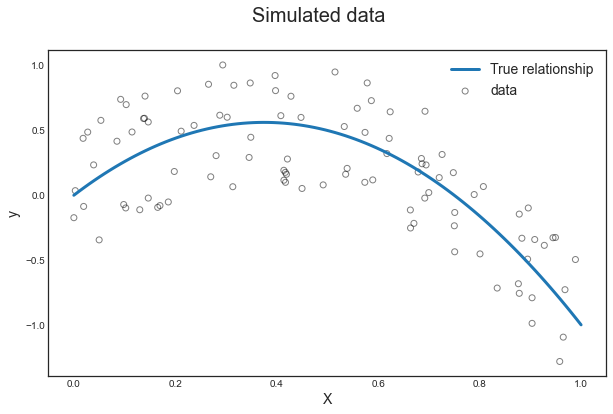

In [34]:
plot_simulated_data(X_sim, y_sim, X_grid, y_grid);

### Fit LL Regression

Now we fit a local linear regression.

In [35]:
# Settings
spec = 'll'
bandwidth = 0.1
kernel = 'gaussian'

# Locally linear regression
local_reg = KernelReg(y_sim, X_sim.reshape(-1,1), 
                      var_type='c', 
                      reg_type=spec, 
                      bw=[bandwidth])
y_hat = KernelReg.fit(local_reg)

What do the parameters mean?
 - `var_type`: dependent variable type (`c` i.e. *continuous*)
 - `reg_type`: local regression specification (`ll` i.e. *locally linear*)
 - `bw`      : bandwidth length (*0.1*)
 - `ckertype`: kernel type (*gaussian*)

### Prediction

What does the prediction looks like?

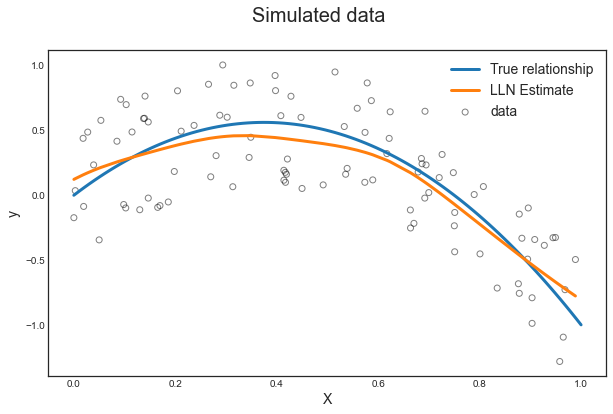

In [36]:
fig, ax = plot_simulated_data(X_sim, y_sim, X_grid, y_grid);
make_figure_7_9a(fig, ax, X_sim, y_hat);

### Details

How exactly was the prediction generated? It was generated pointwise. We are now going to look at the prediction at one particular point: $x_i=0.5$.

We proceed as follows:

1. We select the focal point: $x_i=0.5$
2. We select observations close to $\ x_i$, i.e. $x_{\text{close to i}} = \{ x \in X : |x_i - x| < 0.1 \} \ $ and $ \ y_{\text{close to i}} = \{ y \in Y : |x_i - x| < 0.1 \}$
3. We apply gaussian weights
4. We run a weighted linear regression of $y_{\text{close to i}}$ on $x_{\text{close to i}}$

In [37]:
# Get local X and y
x_i = 0.5
close_to_i = (x_i-bandwidth < X_sim) & (X_sim < x_i+bandwidth)
X_tilde = X_sim[close_to_i]
y_tilde = y_sim[close_to_i]

# Get local estimates
local_estimate = KernelReg.fit(local_reg, data_predict=[x_i])
y_i_hat = local_estimate[0]
beta_i_hat = local_estimate[1]
alpha_i_hat = y_i_hat - beta_i_hat*x_i
print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))

Estimates: alpha=0.7006, beta=-0.6141


### Visualization

Now we can use the locally estimated coefficients to predict the value of $\hat y_i(x_i)$ for $x_i = 0.5$. 

In [38]:
# Build local predictions
close_to_i_grid = (x_i-bandwidth < X_grid) & (X_grid < x_i+bandwidth)
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + X_grid_tilde*beta_i_hat

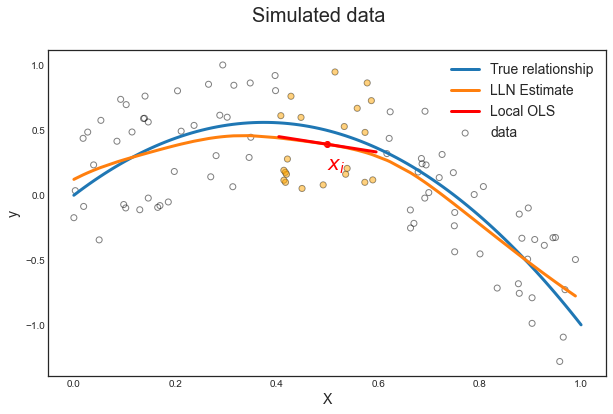

In [39]:
fig, ax = plot_simulated_data(X_sim, y_sim, X_grid, y_grid);
make_figure_7_9a(fig, ax, X_sim, y_hat);
make_figure_7_9b(fig, ax, X_tilde, y_tilde, X_grid_tilde, y_grid_tilde, x_i, y_i_hat)

### Zooming in

We can zoom in and look only at the "*close to i*" sample.

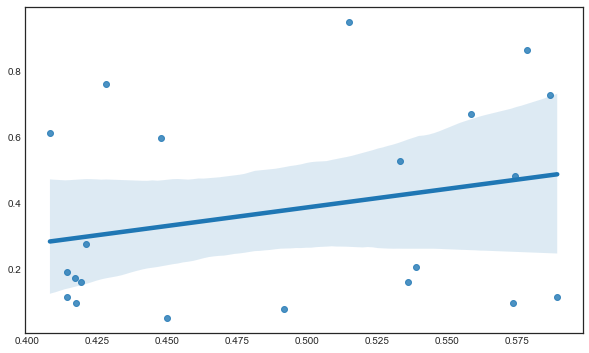

In [40]:
sns.regplot(X_tilde, y_tilde);

Why is the line upward sloped? We forgot the gaussian weights.

In [41]:
# Weights
w = norm.pdf((X_sim-x_i)/bandwidth)

# Estimate LWS
mod_wls = sm.WLS(y_sim, sm.add_constant(X_sim), weights=w)
results = mod_wls.fit()

print('Estimates: alpha=%1.4f, beta=%1.4f' % tuple(results.params))

Estimates: alpha=0.7006, beta=-0.6141


We indeed got the same estimates as before. Note two things:
1. the badwidth defines the scale parameter of the gaussian weights
2. our locally linear regression is acqually global

### Plotting

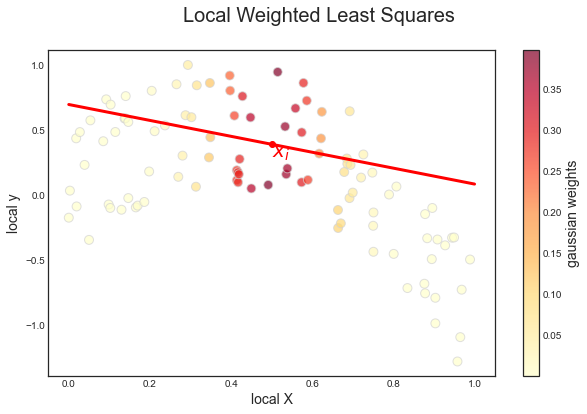

In [42]:
make_figure_7_9d(X_sim, y_sim, w, results, X_grid, x_i, y_i_hat)

Now the slope is indeed negative, as in the locally linear regression.

## Generalized Additive Models

Generalized additive models (GAMs) provide a general framework for extending a standard linear model by allowing non-linear functions of each of the variables, while maintaining additivity.

### GAM for Regression Problems

Imagine to extend the general regression framework to some separabily additive model of the form

$$
y_i = \beta_0 + \sum_{k=1}^K \beta_k f_k(x_{ik}) + \varepsilon_i
$$

It is called an additive model because we calculate a separate $f_k$ for each $X_k$, and then add together all of their contributions.

Consider for example the following model

$$
\text{wage} = \beta_0 + f_1(\text{year}) + f_2(\text{age}) + f_3(\text{education}) + \varepsilon
$$

### Example

We are going to use the following functions:

- $f_1$: natural spline with 8 degrees of freedom
- $f_2$: natural spline with 10 degrees of freedom
- $f_3$: step function

In [43]:
# Set X and y
df['education_'] = LabelEncoder().fit_transform(df["education"])
X = df[['year','age','education_']].to_numpy()
y = df[['wage']].to_numpy()

## model
linear_gam = LinearGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2))
linear_gam.gridsearch(X, y);

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


### Plotting

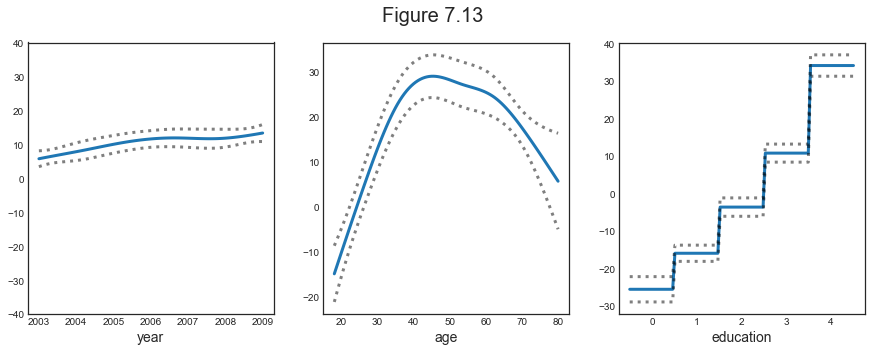

In [44]:
plot_gam(linear_gam)

### Pros and Cons

Before we move on, let us summarize the **advantages** of a GAM.

- GAMs allow us to fit a non-linear $f_k$ to each $X_k$, so that we can automatically model non-linear relationships that standard linear regression will miss
- The non-linear fits can potentially make more accurate predictions
- Because the model is additive, we can still examine the effect of each $X_k$ on $Y$ separately
- The smoothness of the function $f_k$ for the variable $X_k$ can be summarized via degrees of freedom.


The main **limitation** of GAMs is that the model is restricted to be additive. With many variables, important interactions can be missed. However, as with linear regression, we can manually add interaction terms to the GAM model by including additional predictors of the form $X_j \times X_k$. 

### GAMs for Classification Problems

We can use GAMs also with a binary dependent variable.

In [45]:
# Binary dependent variable
y_binary = (y>250)

## Logit link function
logit_gam = LogisticGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2), fit_intercept=True)
logit_gam.gridsearch(X, y_binary);

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


### Plotting

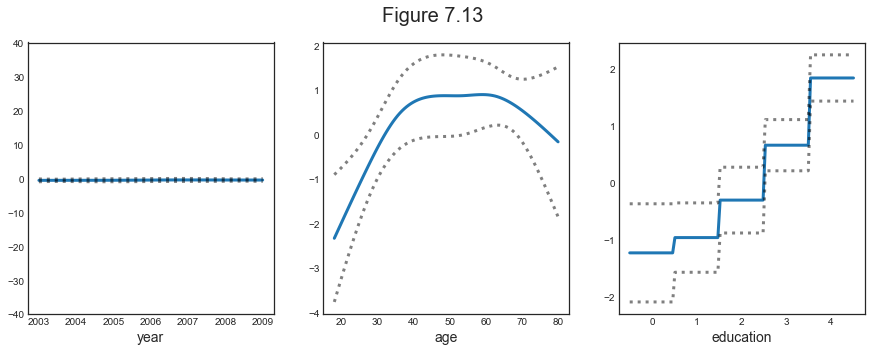

In [46]:
plot_gam(logit_gam)

The results are qualitatively similar to the non-binary case.